# 제주도 도로 교통량 예측 AI 경진대회
- 제주도의 교통 정보로부터 도로 교통량 회귀 예측

## 1. Library & Data Set 불러오기

### 1) Libraryt import

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import matplotlib.pyplot as plt
%matplotlib inline
import gc

### 2) csv to parquet
- 메모리에 효율적인 데이터 유형을 사용하여 용량을 크게 줄이고 빠른 작업 가능

In [2]:
def csv_to_parquet(csv_path, save_name):
    df = pd.read_csv(csv_path)
    df.to_parquet(f'./data/{save_name}.parquet')
    del df
    gc.collect()
    print(save_name, 'Done')

In [3]:
csv_to_parquet('./data/train.csv', 'train')
csv_to_parquet('./data/test.csv', 'test')

train Done
test Done


### 3) 데이터 불러오기

In [4]:
data_info = pd.read_csv('./data/data_info.csv')
train = pd.read_parquet('./data/train.parquet')
test = pd.read_parquet('./data/test.parquet')
submission = pd.read_csv('./data/sample_submission.csv')

## 2. EDA

In [5]:
data_info

,변수명,변수 설명
0,id,아이디
1,base_date,날짜
2,day_of_week,요일
3,base_hour,시간대
4,road_in_use,도로사용여부
5,lane_count,차로수
6,road_rating,도로등급
7,multi_linked,중용구간 여부
8,connect_code,연결로 코드
9,maximum_speed_limit,최고속도제한


In [6]:
train.head()

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,road_type,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target
0,TRAIN_0000000,20220623,목,17,1,106,지방도1112호선,0,0,60.0,...,3,제3교래교,33.427747,126.662612,없음,제3교래교,33.427749,126.662335,없음,52.0
1,TRAIN_0000001,20220728,목,21,2,103,일반국도11호선,0,0,60.0,...,0,광양사거리,33.500730,126.529107,있음,KAL사거리,33.504811,126.526240,없음,30.0
2,TRAIN_0000002,20211010,일,7,2,103,일반국도16호선,0,0,80.0,...,0,창고천교,33.279145,126.368598,없음,상창육교,33.280072,126.362147,없음,61.0
3,TRAIN_0000003,20220311,금,13,2,107,태평로,0,0,50.0,...,0,남양리조트,33.246081,126.567204,없음,서현주택,33.245565,126.566228,없음,20.0
4,TRAIN_0000004,20211005,화,8,2,103,일반국도12호선,0,0,80.0,...,0,애월샷시,33.462214,126.326551,없음,애월입구,33.462677,126.330152,없음,38.0


In [7]:
test.head()

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,height_restricted,road_type,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted
0,TEST_000000,20220825,목,17,3,107,연삼로,0,0,70.0,...,0.0,0,산지2교,33.499427,126.541298,없음,제주은행사거리,33.500772,126.543837,있음
1,TEST_000001,20220809,화,12,2,103,일반국도12호선,0,0,70.0,...,0.0,3,중문입구,33.258507,126.427003,없음,관광단지입구,33.258119,126.415840,없음
2,TEST_000002,20220805,금,2,1,103,일반국도16호선,0,0,60.0,...,0.0,0,도순3교,33.258960,126.476508,없음,도순2교,33.259206,126.474687,없음
3,TEST_000003,20220818,목,23,3,103,일반국도11호선,0,0,70.0,...,0.0,0,아라주공아파트,33.473494,126.545647,없음,인다마을,33.471061,126.545467,없음
4,TEST_000004,20220810,수,17,3,106,번영로,0,0,70.0,...,0.0,0,부록교 시종점,33.501477,126.569223,없음,봉개교 시종점,33.496863,126.581230,없음


In [8]:
submission.head()

,id,target
0,TEST_000000,0
1,TEST_000001,0
2,TEST_000002,0
3,TEST_000003,0
4,TEST_000004,0


In [9]:
# 결측값 확인
train.isna().sum()

id                       0
base_date                0
day_of_week              0
base_hour                0
lane_count               0
road_rating              0
road_name                0
multi_linked             0
connect_code             0
maximum_speed_limit      0
vehicle_restricted       0
weight_restricted        0
height_restricted        0
road_type                0
start_node_name          0
start_latitude           0
start_longitude          0
start_turn_restricted    0
end_node_name            0
end_latitude             0
end_longitude            0
end_turn_restricted      0
target                   0
dtype: int64

In [10]:
train.corr()

,base_date,base_hour,lane_count,road_rating,multi_linked,connect_code,maximum_speed_limit,vehicle_restricted,weight_restricted,height_restricted,road_type,start_latitude,start_longitude,end_latitude,end_longitude,target
base_date,1.000000,-0.008645,0.011463,0.018547,0.000832,-0.010633,-0.018713,NaN,-0.011030,NaN,-0.004599,-0.016818,-0.004954,-0.016786,-0.004972,-0.033997
base_hour,-0.008645,1.000000,-0.029194,0.031658,0.005711,-0.002649,-0.036756,NaN,-0.003231,NaN,-0.007880,-0.021599,-0.011478,-0.021597,-0.011489,-0.159407
lane_count,0.011463,-0.029194,1.000000,-0.095717,-0.026555,-0.029290,0.384002,NaN,-0.177224,NaN,-0.050715,0.182674,-0.094806,0.182330,-0.094732,-0.144256
road_rating,0.018547,0.031658,-0.095717,1.000000,0.024218,-0.054160,-0.327474,NaN,-0.118630,NaN,-0.125618,-0.204793,0.007401,-0.204843,0.007386,-0.261693
multi_linked,0.000832,0.005711,-0.026555,0.024218,1.000000,-0.001111,-0.020245,NaN,-0.008790,NaN,0.042977,-0.014906,0.026895,-0.014907,0.026896,-0.008408
connect_code,-0.010633,-0.002649,-0.029290,-0.054160,-0.001111,1.000000,-0.015190,NaN,-0.020491,NaN,-0.025846,0.036623,-0.045695,0.037163,-0.044853,0.048348
maximum_speed_limit,-0.018713,-0.036756,0.384002,-0.327474,-0.020245,-0.015190,1.000000,NaN,0.085080,NaN,0.059511,0.253147,-0.033018,0.252958,-0.032907,0.425715
vehicle_restricted,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
weight_restricted,-0.011030,-0.003231,-0.177224,-0.118630,-0.008790,-0.020491,0.085080,NaN,1.000000,NaN,0.792803,-0.128291,0.034926,-0.128305,0.034915,0.294092
height_restricted,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:>

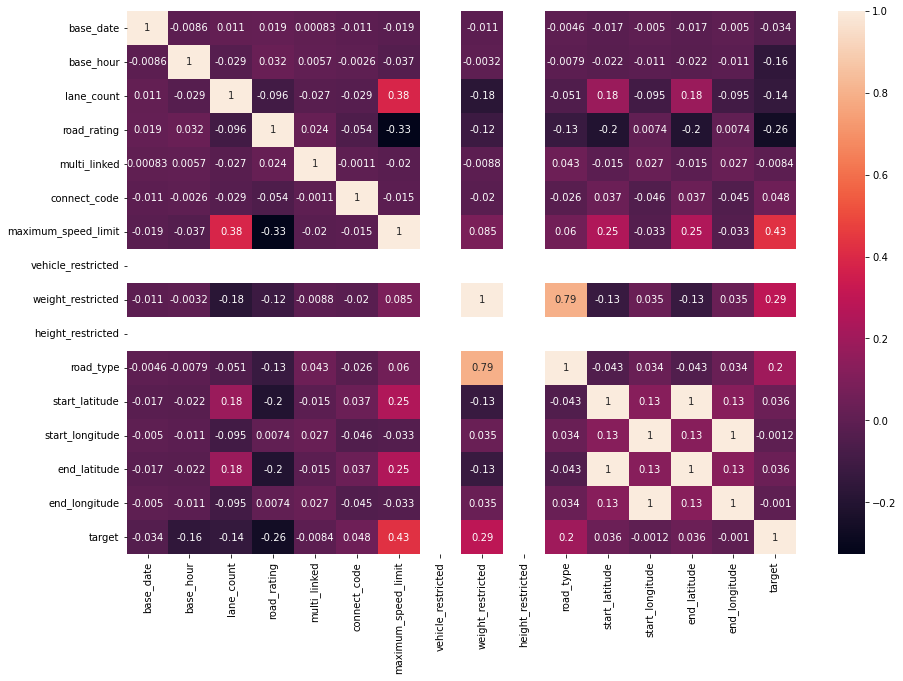

In [11]:
plt.figure(figsize=(15, 10))
sns.heatmap(train.corr(), annot=True)

## 3. 데이터 전처리

### 1) road_name 전처리
- 도로 이름별 taget 평균값으로 랭크 인코딩

In [12]:
rn_rank = train.groupby('road_name').target.mean().reset_index(name='num_rank').sort_values(by='num_rank')
rn_rank

,road_name,num_rank
14,삼무로,15.159959
15,삼봉로,17.024911
18,서사로,19.396394
22,신광로,19.435402
29,연동로,22.564200
...,...,...
27,애조로,57.212785
49,지방도1117호선,58.903308
55,지방도97호선,60.525723
48,지방도1116호선,61.580721


In [13]:
rn_rank['num_rank'] = [i + 1 for i in range(rn_rank.shape[0])]
rn_rank

,road_name,num_rank
14,삼무로,1
15,삼봉로,2
18,서사로,3
22,신광로,4
29,연동로,5
...,...,...
27,애조로,57
49,지방도1117호선,58
55,지방도97호선,59
48,지방도1116호선,60


### 2) 문자열 수치형으로 변환

In [14]:
str_col = ['day_of_week', 'start_turn_restricted', 'end_turn_restricted']
for i in str_col:
    le = LabelEncoder()
    le = le.fit(train[i])
    train[i] = le.transform(train[i])
    
    for label in np.unique(test[i]):
        if label not in le.classes_:
            le.classes_ = np.append(le.classes_, label)
    test[i] = le.transform(test[i])

### 3) 최종 데이터 결합

In [15]:
train = pd.merge(train, rn_rank, how='left')
test = pd.merge(test, rn_rank, how='left')

In [25]:
train

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target,num_rank
0,TRAIN_0000000,20220623,1,17,1,106,지방도1112호선,0,0,60.0,...,제3교래교,33.427747,126.662612,0,제3교래교,33.427749,126.662335,0,52.0,51
1,TRAIN_0000001,20220728,1,21,2,103,일반국도11호선,0,0,60.0,...,광양사거리,33.500730,126.529107,1,KAL사거리,33.504811,126.526240,0,30.0,39
2,TRAIN_0000002,20211010,4,7,2,103,일반국도16호선,0,0,80.0,...,창고천교,33.279145,126.368598,0,상창육교,33.280072,126.362147,0,61.0,46
3,TRAIN_0000003,20220311,0,13,2,107,태평로,0,0,50.0,...,남양리조트,33.246081,126.567204,0,서현주택,33.245565,126.566228,0,20.0,12
4,TRAIN_0000004,20211005,6,8,2,103,일반국도12호선,0,0,80.0,...,애월샷시,33.462214,126.326551,0,애월입구,33.462677,126.330152,0,38.0,45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4701212,TRAIN_4701212,20211104,1,16,1,107,-,0,0,50.0,...,대림사거리,33.422145,126.278125,0,금덕해운,33.420955,126.273750,0,20.0,47
4701213,TRAIN_4701213,20220331,1,2,2,107,-,0,0,80.0,...,광삼교,33.472505,126.424368,0,광삼교,33.472525,126.424890,0,65.0,47
4701214,TRAIN_4701214,20220613,3,22,2,103,일반국도12호선,0,0,60.0,...,고성교차로,33.447183,126.912579,0,성산교차로,33.444121,126.912948,0,30.0,45
4701215,TRAIN_4701215,20211020,2,2,2,103,일반국도95호선,0,0,80.0,...,제6광령교,33.443596,126.431817,0,관광대학입구,33.444996,126.433332,0,73.0,61


## 4. 변수 선택

### 1) 모델링 데이터 구성

In [34]:
# 타겟 값 로그변환
X = train[['day_of_week', 'base_hour', 'lane_count', 'road_rating', 'maximum_speed_limit', 'weight_restricted',
           'road_type', 'start_turn_restricted', 'end_turn_restricted', 'num_rank']]
y = np.log1p(train.target)

In [23]:
test = test[['day_of_week', 'base_hour', 'lane_count', 'road_rating', 'maximum_speed_limit', 'weight_restricted',
                'road_type', 'start_turn_restricted', 'end_turn_restricted', 'num_rank']]

In [35]:
print(X.shape)
print(y.shape)
print(test.shape)

(4701217, 10)
(4701217,)
(291241, 10)


### 2) 5Fold로 교차검증

In [31]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

## 5. 모델링

In [20]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error
from ngboost import NGBRegressor

### 1) LGBMRegressor

In [27]:
lgbm = LGBMRegressor(random_state=518)

In [37]:
mae_list = []
lgbm_pred = np.zeros((test.shape[0]))
for tr_idx, val_idx in kf.split(X, y):
    tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
    val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]
    
    lgbm.fit(tr_x, tr_y)
    
    pred = np.expm1([0 if x < 0 else x for x in lgbm.predict(val_x)])
    sub_pred = np.expm1([0 if x < 0 else x for x in lgbm.predict(test)])
    mae = np.sqrt(mean_absolute_error(val_y, pred))
    mae_list.append(mae)
    
    lgbm_pred += (sub_pred / 5)

In [38]:
lgbm_mae = np.mean(mae_list)
lgbm_mae

6.163437038147132

In [39]:
submission['target'] = lgbm_pred
submission.sort_values(by='target')

,id,target
288559,TEST_288559,9.713810
275572,TEST_275572,9.713810
176036,TEST_176036,9.713810
181338,TEST_181338,9.713810
5973,TEST_005973,10.043375
...,...,...
224661,TEST_224661,74.893163
242108,TEST_242108,74.893163
98269,TEST_098269,74.893163
252280,TEST_252280,74.893163


In [40]:
submission.to_csv('./result/lgbm.csv', index=False)